In [26]:
import pandas as pd
import pickle
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

# Data Cleaning

In [27]:
df_historical_data = pd.read_csv('data/fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('data/fifa_worldcup_fixture.csv')
df_missing_data = pd.read_csv('data/fifa_worldcup_missing_data.csv')

## Làm sạch file df_fixture

In [29]:
df_fixture['home'] = df_fixture['home'].str.strip()
df_fixture['away'] = df_fixture['away'].str.strip()

In [30]:
df_fixture

,home,score,away,year
0,Qatar,Match 1,Ecuador,2022
1,Senegal,Match 2,Netherlands,2022
2,Qatar,Match 18,Senegal,2022
3,Netherlands,Match 19,Ecuador,2022
4,Ecuador,Match 35,Senegal,2022
...,...,...,...,...
59,Winners Match 51,Match 59,Winners Match 52,2022
60,Winners Match 57,Match 61,Winners Match 58,2022
61,Winners Match 59,Match 62,Winners Match 60,2022
62,Losers Match 61,Match 63,Losers Match 62,2022


## Làm sạch file df_missing_data và thêm nó vào file df_historical_data

In [32]:
df_missing_data.isnull()
df_missing_data.dropna(inplace=True)
df_historical_data = pd.concat([df_historical_data, df_missing_data], ignore_index=True)
df_historical_data.drop_duplicates(inplace=True)
df_historical_data.sort_values('year', inplace=True)
df_historical_data

,home,score,away,year
0,France,4–1,Mexico,1930
17,Uruguay,4–2,Argentina,1930
16,Uruguay,6–1,Yugoslavia,1930
15,Argentina,6–1,United States,1930
14,Paraguay,1–0,Belgium,1930
...,...,...,...,...
419,Brazil,2–0,Costa Rica,2018
420,Serbia,1–2,Switzerland,2018
421,Serbia,0–2,Brazil,2018
408,France,1–0,Peru,2018


In [33]:
df_missing_data

,home,score,away,year
0,Mexico,0–0,Soviet Union,1970
1,Belgium,3–0,El Salvador,1970
2,Soviet Union,4–1,Belgium,1970
3,Mexico,4–0,El Salvador,1970
4,Soviet Union,2–0,El Salvador,1970
...,...,...,...,...
503,Spain,0–1,Switzerland,2010
504,Chile,1–0,Switzerland,2010
505,Spain,2–0,Honduras,2010
506,Chile,1–2,Spain,2010


## Làm sạch file df_historical_data

In [35]:
# Xóa dữ liệu những trận bị xử thua 0-3 do đội không thi đấu
delete_index = df_historical_data[df_historical_data['home'].str.contains('Sweden') &
                                  df_historical_data['away'].str.contains('Austria')].index

df_historical_data.drop(index=delete_index, inplace=True)

# căn chỉnh lại khoảng trắng cho các cột score, home, way tương tự ở trên với hàm str strip()
df_historical_data['score'] = df_historical_data['score'].str.replace('[^\d–]', '', regex=True)
df_historical_data['home'] = df_historical_data['home'].str.strip() 
df_historical_data['away'] = df_historical_data['away'].str.strip()

# tách cột tỷ số thành bàn thắng sân nhà và sân khách và bỏ cột tỷ số
df_historical_data[['HomeGoals', 'AwayGoals']] = df_historical_data['score'].str.split('–', expand=True)
df_historical_data.drop('score', axis=1, inplace=True)

# Đổi tên các cột, và thay đổi kiểu dữ liệu của chúng
df_historical_data.rename(columns={'home': 'HomeTeam', 'away': 'AwayTeam', 
                                   'year':'Year'}, inplace=True)
df_historical_data = df_historical_data.astype({'HomeGoals': int, 'AwayGoals':int, 'Year': int})

# Thêm một cột totalgoals = home goals + away goals
df_historical_data['TotalGoals'] = df_historical_data['HomeGoals'] + df_historical_data['AwayGoals']
df_historical_data

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
17,Uruguay,Argentina,1930,4,2,6
16,Uruguay,Yugoslavia,1930,6,1,7
15,Argentina,United States,1930,6,1,7
14,Paraguay,Belgium,1930,1,0,1
...,...,...,...,...,...,...
419,Brazil,Costa Rica,2018,2,0,2
420,Serbia,Switzerland,2018,1,2,3
421,Serbia,Brazil,2018,0,2,2
408,France,Peru,2018,1,0,1


In [36]:
## Xuất file được làm sạch với tiền tố clean
df_historical_data.to_csv('data/clean_fifa_worldcup_matches.csv',index=False)
df_fixture.to_csv('data/clean_fifa_worldcup_fixture.csv',index=False)

In [37]:
## Kiểm tra và sắp xếp lại các kì World Cup sao cho ứng với tổng trận đấu
# Xác nhận lại các 
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]

for year in years:
    print(year, len(df_historical_data[df_historical_data['Year']==year]))

1930 18
1934 17
1938 18
1950 22
1954 26
1958 35
1962 32
1966 32
1970 32
1974 38
1978 38
1982 52
1986 52
1990 52
1994 52
1998 64
2002 64
2006 64
2010 64
2014 64
2018 64


In [38]:
# Kiểm tra lại file đã làm sạch với trừng hợp xấu nhất là của Sweden
print(df_historical_data[df_historical_data['HomeTeam'].str.contains('Sweden')])
print(df_historical_data[df_historical_data['AwayTeam'].str.contains('Sweden')])

    HomeTeam      AwayTeam  Year  HomeGoals  AwayGoals  TotalGoals
23    Sweden     Argentina  1934          3          2           5
46    Sweden          Cuba  1938          8          0           8
66    Sweden         Italy  1950          3          2           5
67    Sweden      Paraguay  1950          2          2           4
74    Sweden         Spain  1950          3          1           4
134   Sweden  West Germany  1958          3          1           4
131   Sweden  Soviet Union  1958          2          0           2
119   Sweden         Wales  1958          0          0           0
118   Sweden       Hungary  1958          2          1           3
115   Sweden        Mexico  1958          3          0           3
466   Sweden        Israel  1970          1          1           2
498   Sweden       Uruguay  1974          3          0           3
494   Sweden      Bulgaria  1974          0          0           0
512   Sweden        Poland  1974          0          1        

# Data Visualization

In [39]:
# chạy file player_22
df = pd.read_csv('data/players_22.csv', low_memory=False)

# chỉ chọn những cột sau để thực hiện mô hình hóa
df = df[['short_name', 'age', 'nationality_name', 'overall', 'potential',
         'club_name', 'value_eur', 'wage_eur', 'player_positions']]

# chọn ra vị trí mà cầu thủ chơi tốt nhất
df['player_positions'] = df['player_positions'].str.split(',', expand=True)[0]

# loại bỏ những cầu thủ bị thiếu chỉ số hoặc có dòng bị NaN
df.dropna(inplace=True)

players_missing_worldcup = ['K. Benzema', 'S. Mané', 'S. Agüero', 'Sergio Ramos', 'P. Pogba',
                            'M. Reus', 'Diogo Jota', 'A. Harit', 'N. Kanté', 'G. Lo Celso', 'Piqué']

# loại những cầu thủ bị chấn thương hoặc không được triệu tập lên đội tuyển
drop_index = df[df['short_name'].isin(players_missing_worldcup)].index
df.drop(drop_index, axis=0, inplace=True)

teams_worldcup = [
    'Qatar', 'Brazil', 'Belgium', 'France', 'Argentina', 'England', 'Spain', 'Portugal',
    'Mexico', 'Netherlands', 'Denmark', 'Germany', 'Uruguay', 'Switzerland', 'United States', 'Croatia',
    'Senegal', 'Iran', 'Japan', 'Morocco', 'Serbia', 'Poland', 'South Korea', 'Tunisia',
    'Cameroon', 'Canada', 'Ecuador', 'Saudi Arabia', 'Ghana', 'Wales', 'Costa Rica', 'Australia'
]

# Sap xep chi co nhung doi tuyen quoc gia duoc tham du World Cup
df = df[df['nationality_name'].isin(teams_worldcup)]

# xây dựng hàm đánh giá cầu thủ theo 3 tiêu chí
df.sort_values(by=['overall', 'potential', 'value_eur'], ascending=False, inplace=True)

# Tổng quát về phân bố năng lực cầu thủ trong kì World Cup 2022

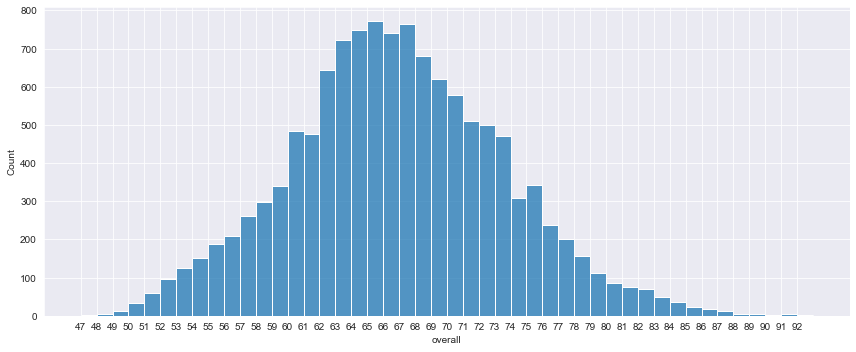

In [40]:
import numpy as np
fig, ax = plt.subplots(figsize=(12, 5), tight_layout=True)

sns.histplot(df, x='overall', binwidth=1)

bins = np.arange(df['overall'].min(), df['overall'].max(), 1)
plt.xticks(bins)
plt.show()

# Đội hình mạnh nhất của kì World Cup 2022 theo số liệu 

In [41]:
df.drop_duplicates('player_positions')

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
0,L. Messi,34,Argentina,93,93,Paris Saint-Germain,78000000.0,320000.0,RW
1,R. Lewandowski,32,Poland,92,92,FC Bayern München,119500000.0,270000.0,ST
3,Neymar Jr,29,Brazil,91,91,Paris Saint-Germain,129000000.0,270000.0,LW
4,K. De Bruyne,30,Belgium,91,91,Manchester City,125500000.0,350000.0,CM
8,M. ter Stegen,29,Germany,90,92,FC Barcelona,99000000.0,250000.0,GK
19,J. Kimmich,26,Germany,89,90,FC Bayern München,108000000.0,160000.0,CDM
15,V. van Dijk,29,Netherlands,89,89,Liverpool,86000000.0,230000.0,CB
28,Bruno Fernandes,26,Portugal,88,89,Manchester United,107500000.0,250000.0,CAM
44,T. Alexander-Arnold,22,England,87,92,Liverpool,114000000.0,150000.0,RB
45,J. Sancho,21,England,87,91,Manchester United,116500000.0,150000.0,RM


# Đội hình tốt nhất của mỗi đội tuyển

In [48]:
def best_squad(nationality):
    df_best_squad = df.copy()
    df_best_squad = df_best_squad.groupby(['nationality_name', 'player_positions']).head(2)
    df_best_squad = df_best_squad[df_best_squad['nationality_name']==nationality].sort_values(['player_positions', 'overall', 'potential'], ascending=False)
    return df_best_squad

best_squad('Brazil')

,short_name,age,nationality_name,overall,potential,club_name,value_eur,wage_eur,player_positions
191,Gabriel Jesus,24,Brazil,83,87,Manchester City,52500000.0,150000.0,ST
268,Richarlison,24,Brazil,82,87,Everton,46500000.0,100000.0,ST
5069,Paolinho Leima,21,Brazil,70,70,Clube Atlético Mineiro,1700000.0,12000.0,RWB
8031,Jadenilson Baia,33,Brazil,67,67,Sport Club Corinthians Paulista,525000.0,9000.0,RWB
662,Antony,21,Brazil,79,88,Ajax,39500000.0,17000.0,RW
656,Rodrygo,20,Brazil,79,88,Real Madrid CF,38500000.0,115000.0,RW
271,Raphinha,24,Brazil,82,87,Leeds United,46000000.0,89000.0,RM
318,Lucas Moura,28,Brazil,81,81,Tottenham Hotspur,26000000.0,105000.0,RM
311,Danilo,29,Brazil,81,81,Juventus,22500000.0,83000.0,RB
484,Maikel Catarino,25,Brazil,80,80,Sport Club Corinthians Paulista,21000000.0,33000.0,RB


In [49]:
average_overall = [best_squad(team)['overall'].mean() for team in teams_worldcup]

df_average_overall = pd.DataFrame({'Teams': teams_worldcup, 'AVG_Overall': average_overall})
df_average_overall = df_average_overall.dropna()
df_average_overall = df_average_overall.sort_values('AVG_Overall', ascending=False)
df_average_overall

,Teams,AVG_Overall
6,Spain,82.400000
7,Portugal,81.733333
5,England,81.700000
1,Brazil,81.666667
3,France,81.000000
4,Argentina,80.566667
11,Germany,80.433333
2,Belgium,79.034483
9,Netherlands,78.758621
8,Mexico,77.727273


# Sơ đồ ra sân tốt nhất của từng đội tuyển

In [50]:
def best_lineup(nationality, lineup):
    lineup_count = [lineup.count(i) for i in lineup]

    df_lineup = pd.DataFrame({'position': lineup, 'count': lineup_count})
    positions_non_repeated = df_lineup[df_lineup['count'] <= 1]['position'].values
    positions_repeated = df_lineup[df_lineup['count'] > 1]['position'].values

    df_squad = best_squad(nationality)

    df_lineup = pd.concat([
        df_squad[df_squad['player_positions'].isin(positions_non_repeated)].drop_duplicates('player_positions', keep='first'),
        df_squad[df_squad['player_positions'].isin(positions_repeated)]]
    )
    return df_lineup[['short_name', 'overall', 'club_name', 'player_positions']]

dict_formation = {
    '4-3-3': ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CM', 'CAM', 'RW', 'ST', 'LW'],
    '4-4-2': ['GK', 'RB', 'CB', 'CB', 'LB', 'RM', 'CM', 'CM', 'LM', 'ST', 'ST'],
    '4-2-3-1': ['GK', 'RB', 'CB', 'CB', 'LB', 'CDM', 'CDM', 'CAM', 'CAM', 'CAM', 'ST'],
}

for index, row in df_average_overall[:9].iterrows():
    max_average = None
    for key, values in dict_formation.items():
        average = best_lineup(row['Teams'], values)['overall'].mean()
        if max_average is None or average>max_average:
            max_average = average
            formation = key
    print(row['Teams'], formation, max_average)

Spain 4-2-3-1 85.1
Portugal 4-2-3-1 84.9
England 4-4-2 84.45454545454545
Brazil 4-3-3 84.81818181818181
France 4-2-3-1 83.9
Argentina 4-3-3 83.54545454545455
Germany 4-2-3-1 84.1
Belgium 4-3-3 82.54545454545455
Netherlands 4-4-2 82.54545454545455


In [51]:
# best_lineup('Spain', dict_formation['4-2-3-1'])
# best_lineup('Argentina', dict_formation['4-3-3'])
best_lineup('Portugal', dict_formation['4-3-3'])

,short_name,overall,club_name,player_positions
2,Cristiano Ronaldo,91,Manchester United,ST
381,Pedro Gonçalves,81,Sporting CP,RW
62,João Cancelo,86,Manchester City,RB
286,Nani,81,Orlando City Soccer Club,LW
124,R. Guerreiro,84,Borussia Dortmund,LB
226,A. Lopes,82,Olympique Lyonnais,GK
255,Rúben Neves,82,Wolverhampton Wanderers,CM
260,Palhinha,82,Sporting CP,CDM
28,Bruno Fernandes,88,Manchester United,CAM
46,Rúben Dias,87,Manchester City,CB


# Predict World Cup 2022 with Poissons Distribution

In [52]:
dict_table = pickle.load(open('data/dict_table','rb'))
df_historical_data = pd.read_csv('data/clean_fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('data/clean_fifa_worldcup_fixture.csv')

In [53]:
dict_table

{'Group A':    Pos         Team  Pld  W  D  L  GF  GA  GD  Pts
 0    1    Qatar (H)    0  0  0  0   0   0   0    0
 1    2      Ecuador    0  0  0  0   0   0   0    0
 2    3      Senegal    0  0  0  0   0   0   0    0
 3    4  Netherlands    0  0  0  0   0   0   0    0,
 'Group B':    Pos           Team  Pld  W  D  L  GF  GA  GD  Pts
 0    1        England    0  0  0  0   0   0   0    0
 1    2           Iran    0  0  0  0   0   0   0    0
 2    3  United States    0  0  0  0   0   0   0    0
 3    4          Wales    0  0  0  0   0   0   0    0,
 'Group C':    Pos          Team  Pld  W  D  L  GF  GA  GD  Pts
 0    1     Argentina    0  0  0  0   0   0   0    0
 1    2  Saudi Arabia    0  0  0  0   0   0   0    0
 2    3        Mexico    0  0  0  0   0   0   0    0
 3    4        Poland    0  0  0  0   0   0   0    0,
 'Group D':    Pos       Team  Pld  W  D  L  GF  GA  GD  Pts
 0    1     France    0  0  0  0   0   0   0    0
 1    2  Australia    0  0  0  0   0   0   0    0
 2    3 

# Tính toán sức mạnh của đội hình

In [54]:
df_home = df_historical_data[['HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away = df_historical_data[['AwayTeam', 'HomeGoals', 'AwayGoals']]

df_home = df_home.rename(columns={'HomeTeam':'Team', 'HomeGoals': 'GoalsScored', 'AwayGoals': 'GoalsConceded'})
df_away = df_away.rename(columns={'AwayTeam':'Team', 'HomeGoals': 'GoalsConceded', 'AwayGoals': 'GoalsScored'})

df_team_strength = pd.concat([df_home, df_away], ignore_index=True).groupby(['Team']).mean()
df_team_strength

,GoalsScored,GoalsConceded
Team,,
Algeria,1.000000,1.461538
Angola,0.333333,0.666667
Argentina,1.691358,1.148148
Australia,0.812500,1.937500
Austria,1.482759,1.620690
...,...,...
Uruguay,1.553571,1.321429
Wales,0.800000,0.800000
West Germany,2.112903,1.241935


# Hàm dự đoán số điểm(predict_points)

In [55]:
def predict_points(home, away):
    if home in df_team_strength.index and away in df_team_strength.index:
        lamb_home = df_team_strength.at[home,'GoalsScored'] * df_team_strength.at[away,'GoalsConceded']
        lamb_away = df_team_strength.at[away,'GoalsScored'] * df_team_strength.at[home,'GoalsConceded']
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11):
            for y in range(0, 11):
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)

## Chạy thử hàm

In [56]:
print(predict_points('England', 'United States'))
print(predict_points('Argentina', 'Mexico'))
print(predict_points('Qatar (H)', 'Ecuador'))

(2.2356147635326007, 0.5922397535606193)
(2.3129151525530505, 0.5378377125059863)
(0, 0)


# Dự đoán kết quả WorldCup

## Vòng Bảng(Group States)

In [57]:
df_fixture_group_48 = df_fixture[:48].copy()
df_fixture_knockout = df_fixture[48:56].copy()
df_fixture_quarter = df_fixture[56:60].copy()
df_fixture_semi = df_fixture[60:62].copy()
df_fixture_final = df_fixture[62:].copy()

In [58]:
for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    df_fixture_group_6 = df_fixture_group_48[df_fixture_group_48['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
        dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away

    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)

In [59]:
dict_table['Group A']

,Team,Pts
0,Netherlands,4.0
1,Senegal,2.0
2,Ecuador,2.0
3,Qatar (H),0.0


In [60]:
df_fixture_group_6

,home,score,away,year
42,Uruguay,Match 14,South Korea,2022
43,Portugal,Match 15,Ghana,2022
44,South Korea,Match 30,Ghana,2022
45,Portugal,Match 32,Uruguay,2022
46,Ghana,Match 45,Uruguay,2022
47,South Korea,Match 46,Portugal,2022


## Vòng loại trực tiếp(Knock_out)

In [61]:
df_fixture_knockout

,home,score,away,year
48,Winners Group A,Match 49,Runners-up Group B,2022
49,Winners Group C,Match 50,Runners-up Group D,2022
50,Winners Group D,Match 52,Runners-up Group C,2022
51,Winners Group B,Match 51,Runners-up Group A,2022
52,Winners Group E,Match 53,Runners-up Group F,2022
53,Winners Group G,Match 54,Runners-up Group H,2022
54,Winners Group F,Match 55,Runners-up Group E,2022
55,Winners Group H,Match 56,Runners-up Group G,2022


In [62]:
for group in dict_table:
    group_winner = dict_table[group].loc[0, 'Team']
    runners_up = dict_table[group].loc[1, 'Team']
    df_fixture_knockout.replace({f'Winners {group}':group_winner,
                                 f'Runners-up {group}':runners_up}, inplace=True)

df_fixture_knockout['winner'] = '?'
df_fixture_knockout

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,?
49,Argentina,Match 50,Denmark,2022,?
50,France,Match 52,Poland,2022,?
51,England,Match 51,Senegal,2022,?
52,Germany,Match 53,Belgium,2022,?
53,Brazil,Match 54,Uruguay,2022,?
54,Croatia,Match 55,Spain,2022,?
55,Portugal,Match 56,Switzerland,2022,?


In [63]:
def get_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        if points_home > points_away:
            winner = home
        else:
            winner = away
        df_fixture_updated.loc[index, 'winner'] = winner
    return df_fixture_updated

In [64]:
get_winner(df_fixture_knockout)

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,Netherlands
49,Argentina,Match 50,Denmark,2022,Argentina
50,France,Match 52,Poland,2022,France
51,England,Match 51,Senegal,2022,England
52,Germany,Match 53,Belgium,2022,Germany
53,Brazil,Match 54,Uruguay,2022,Brazil
54,Croatia,Match 55,Spain,2022,Spain
55,Portugal,Match 56,Switzerland,2022,Portugal


## Tứ Kết(Quarter Final)

In [65]:
def update_table(df_fixture_round_1, df_fixture_round_2):
    for index, row in df_fixture_round_1.iterrows():
        winner = df_fixture_round_1.loc[index, 'winner']
        match = df_fixture_round_1.loc[index, 'score']
        df_fixture_round_2.replace({f'Winners {match}':winner}, inplace=True)
    df_fixture_round_2['winner'] = '?'
    return df_fixture_round_2

In [66]:
update_table(df_fixture_knockout, df_fixture_quarter)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,?
57,Netherlands,Match 57,Argentina,2022,?
58,Spain,Match 60,Portugal,2022,?
59,England,Match 59,France,2022,?


In [67]:
get_winner(df_fixture_quarter)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,Brazil
57,Netherlands,Match 57,Argentina,2022,Netherlands
58,Spain,Match 60,Portugal,2022,Portugal
59,England,Match 59,France,2022,France


## Bán kết(SemiFinal)

In [68]:
update_table(df_fixture_quarter, df_fixture_semi)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,?
61,France,Match 62,Portugal,2022,?


In [69]:
get_winner(df_fixture_semi)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,Brazil
61,France,Match 62,Portugal,2022,France


## Chung Kết(Final)

In [70]:
update_table(df_fixture_semi, df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,?
63,Brazil,Match 64,France,2022,?


In [71]:
get_winner(df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,Losers Match 62
63,Brazil,Match 64,France,2022,Brazil
